In [1]:
import scvi
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
import anndata as ad
from anndata import AnnData
import matplotlib

# Hierarchical Integration: scANVI

In [2]:
target2 = sc.read_h5ad("/vol/data/ouologuems/data/preprocessed/target2_spherized_woSource9.h5ad")
target2

/vol/data/ouologuems/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 50376 × 601
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType', 'SMILES_original', 'SMILES_standardized', 'InChI_standardized', 'InChIKey_standardized', 'broad_sample', 'InChIKey', 'pert_iname', 'pubchem_cid', 'target', 'pert_type', 'control_type', 'moa'
    uns: 'Metadata_Source_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/vol/data/ouologuems/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


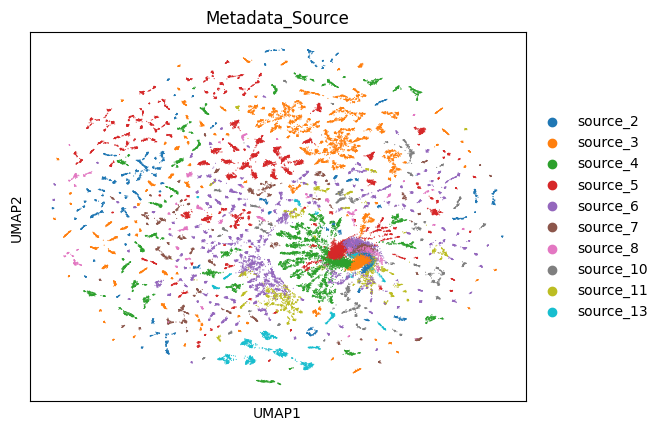

In [3]:
sc.pl.umap(target2, color = "Metadata_Source")

In [4]:
def scanvi_integration(
    adata: AnnData,
    batch: str,
    labels: str,
    max_epochs: int = 400,
    hierarchical: str = None,
) -> AnnData:
    """Function to perfrom integration with scanVI

    Computes corrected feature matrix and embedding representation.
    When this method is called on a higher level (i.e. use output
    of previous run as input), one should call `reset_corrected_anndata`
    on the input before. Else, the original data from adata.X is used
    for the next level and not the corrected values.

    Args:
        adata:          AnnData object containing the data
        batch:          Name of the column in adata.obs which contains
                        the batch labels
        labels:         Name of the column in adata.obs which contains
                        the biological labels
        max_epochs:     Max number of epochs for training the model
        hierarchical:   Doesn't have an influence on the batch correction
                        when None. Else: correction of a "lower level"
                        of nested batch effects. The batch correction is
                        then performed separately for each group that is
                        defined by the column hierarchical in adata.obs

    Returns:
        AnnData:        Batch corrected AnnData object
    """
    scanvi_adata = adata.copy()
    # min-max scaling because else you get exploding gradients
    scaler = MinMaxScaler()
    scanvi_adata.X = scaler.fit_transform(scanvi_adata.X)
    scanvi_adata.layers["counts"] = scanvi_adata.X

    if isinstance(hierarchical, str):
        # do batch correction on lower level (iterate over high-level batches)
        scvi_results = []
        for group in scanvi_adata.obs[hierarchical].unique():
            adata_part = scanvi_adata[scanvi_adata.obs[hierarchical] == group].copy()
            scvi.model.SCANVI.setup_anndata(adata_part, batch_key=batch, labels_key=labels, unlabeled_category="NA")
            model = scvi.model.SCANVI(adata_part, gene_likelihood="normal", n_latent=30)
            model.train()
            SCANVI_LATENT_KEY = "X_scanvi"
            adata_part.obsm[SCANVI_LATENT_KEY] = model.get_latent_representation()
            scvi_results.append(adata_part)
        scanvi_adata = ad.concat(scvi_results, merge="same")
        return scanvi_adata
    else:
        # do batch correction over all observations at once
        scvi.model.SCANVI.setup_anndata(scanvi_adata, batch_key=batch, labels_key=labels, unlabeled_category="NA")
        model = scvi.model.SCANVI(scanvi_adata, gene_likelihood="normal")
        model.train()
        SCANVI_LATENT_KEY = "X_scanvi"
        scanvi_adata.obsm[SCANVI_LATENT_KEY] = model.get_latent_representation()
        return scanvi_adata

In [5]:
def reset_corrected_anndata(adata: AnnData, obsm_key: str = "X_emb") -> AnnData:
    """Prepare corrected AnnData object for next level of batch correction

    After batch correction, this method creates a new AnnData object from
    a corrected one where the corrected features (usually in X_emb) are
    saved in X. This is helpful if you want to iterate batch correction
    methods on different levels to remove nested batch effects.

    Args:
        adata:          AnnData object containing the corrected data
        obsm_key:       Key under which the corrected data is stored
                        in obsm of `adata`

    Returns:
        AnnData:        AnnData object with X_emb saved in X
    """
    new_adata = ad.AnnData(adata.obsm[obsm_key].copy())
    new_adata.obs = adata.obs.copy()
    return new_adata


Low level correction:

In [6]:
adata_scanvi_per_source = scanvi_integration(target2, batch= "Metadata_Plate", hierarchical="Metadata_Source", labels= "Metadata_JCP2022")

/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [15:03<00:00,  2.25s/it, v_num=1, train_loss_step=-1.5e+3, train_loss_epoch=-1.81e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [15:03<00:00,  2.26s/it, v_num=1, train_loss_step=-1.5e+3, train_loss_epoch=-1.81e+3]
INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [17:02<00:00,  2.62s/it, v_num=1, train_loss_step=-1.49e+3, train_loss_epoch=-1.62e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [17:02<00:00,  2.56s/it, v_num=1, train_loss_step=-1.49e+3, train_loss_epoch=-1.62e+3]
INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [14:19<00:00,  2.11s/it, v_num=1, train_loss_step=-2.29e+3, train_loss_epoch=-2.32e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:19<00:00,  2.15s/it, v_num=1, train_loss_step=-2.29e+3, train_loss_epoch=-2.32e+3]
INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 165/400:  41%|████      | 164/400 [09:39<13:48,  3.51s/it, v_num=1, train_loss_step=-1.73e+3, train_loss_epoch=-1.73e+3]INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 2/400:   0%|          | 1/400 [00:09<1:04:17,  9.67s/it, v_num=1, train_loss_step=739, train_loss_epoch=791]INFO     Training for 400 epochs.                                                                                  


/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/vol/data/ouologuems/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/vol/data/ouologuems/miniconda3/envs/gaushvi/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 2/400:   0%|          | 1/400 [00:07<53:04,  7.98s/it, v_num=1, train_loss_step=755, train_loss_epoch=819]

In [ ]:
sc.pp.neighbors(adata_scanvi_per_source, use_rep="X_scvi")
sc.tl.umap(adata_scanvi_per_source)
sc.pl.umap(adata_scanvi_per_source, color="Metadata_Source")
sc.pl.umap(adata_scanvi_per_source, color="Metadata_Plate",palette=list(matplotlib.colors.CSS4_COLORS.values()))

High level correction: 

In [ ]:
adata_scanvi_overall = scanvi_integration(reset_corrected_anndata(adata_scanvi_per_source, obsm_key = "X_scanvi"), batch="Metadata_Source", labels="Metadata_JCP2022")

In [ ]:
sc.pp.neighbors(adata_scanvi_overall, use_rep="X_scanvi")
sc.tl.umap(adata_scanvi_overall)
sc.pl.umap(adata_scanvi_overall, color="Metadata_Source")
sc.pl.umap(adata_scanvi_overall, color="Metadata_Plate",palette=list(matplotlib.colors.CSS4_COLORS.values()))